In [358]:
import os
os.system('cls' if os.name == 'nt' else 'clear')

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import importlib  # Pour recharger le module
pd.set_option('future.no_silent_downcasting', True)
from decimal import Decimal, getcontext

# Foyer

In [314]:
option = "sto"

if option == "recipient" : 
    import battery_optimizer_recipient
    importlib.reload(battery_optimizer_recipient)
    df, duree = battery_optimizer_recipient.export_df_for_graph()
elif option == "sto" : 
    import battery_optimizer_recipient_sto
    importlib.reload(battery_optimizer_recipient_sto)
    df, SEMAINES = battery_optimizer_recipient_sto.export_df_for_graph()


hiver
printemps
ete
automne


,Saison,Date,Heure,Demande,Prod PV,SOC_t,Vente,Achat,Well,Prix elec
230,hiver,1/10/2021,14,0.89,0.11,0.0,0.0,0.78,0,4.330
231,hiver,1/10/2021,15,0.85,0.07,0.0,0.0,3.78,0,4.233
232,hiver,1/10/2021,16,0.86,0.00,3.0,0.0,3.86,0,4.213
233,hiver,1/10/2021,17,0.92,0.00,6.0,0.0,0.92,0,4.283
234,hiver,1/10/2021,18,1.02,0.00,6.0,0.0,1.02,0,4.507
235,hiver,1/10/2021,19,1.06,0.00,6.0,2.0,0.06,0,4.641
236,hiver,1/10/2021,20,1.01,0.00,3.0,2.0,0.01,0,4.591
237,hiver,1/10/2021,21,0.92,0.00,0.0,0.0,0.92,0,4.478
238,hiver,1/10/2021,22,0.82,0.00,0.0,0.0,3.82,0,4.407
239,hiver,1/10/2021,23,0.74,0.00,3.0,2.3,0.04,0,4.485


Taille finale : 672 lignes

Time: 405.97


In [ ]:
col_ajoutee = ("SOC_charge", "SOC_decharge", "Achat_t", "Well_0")
# Supprimer les colonnes ajoutées si elles existent déjà pour éviter les problèmes
for col in col_ajoutee : 
    if col in df.columns:
        df.drop(columns=[col], inplace=True)


# Configurer la précision
getcontext().prec = 4  # 4 chiffres significatifs

# Appliquer aux données
df["Well"] = df["Well"].apply(lambda x: float(Decimal(str(x)).quantize(Decimal('0.001'))))
df["SOC_decharge"] = (df["Demande"] + df["Vente"] - df["Prod PV"] - df["Achat"]).clip(lower=0).round(3)
df["Achat_t"] = (df["Demande"] - df["Prod PV"] - df["SOC_t"]).clip(lower=0)
df["Well_0"] = (df["Prod PV"] - df["Demande"] - df["Vente"]).clip(lower=0).round(3)

# df.to_csv('/Users/vincentboltz/Documents/DOC_ENPC/Projet_IFPEN/Données brut/df_for_graph.csv', index=False, header=True)

# display(df.iloc[0:60])
def display_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    display(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
display_full(df[df['Saison'] == 'ete'])

for semaine in SEMAINES.keys() :
    print(f'\n{semaine} : ')
    print(f'Well avec batterie tot = {df[df['Saison'] == semaine]['Well'].sum()} kWh')
    print(f'Prod PV tot = {df[df['Saison'] == semaine]['Prod PV'].sum().round(3)} kWh')
    print(f'Well sans batterie tot = {df[df['Saison'] == semaine]['Well_0'].sum().round(3)} kWh')



,Saison,Date,Heure,Demande,Prod PV,SOC_t,Vente,Achat,Well,Prix elec,SOC_decharge,Achat_t,Well_0
4440,ete,7/5/2021,0,0.20,0.00,0.00,0.00,0.20,0.00,3.06,0.00,0.20,0.00
4441,ete,7/5/2021,1,0.19,0.00,0.00,0.00,0.19,0.00,2.88,0.00,0.19,0.00
4442,ete,7/5/2021,2,0.18,0.00,0.00,0.00,0.18,0.00,2.82,0.00,0.18,0.00
4443,ete,7/5/2021,3,0.18,0.00,0.00,0.00,3.18,0.00,2.70,0.00,0.18,0.00
4444,ete,7/5/2021,4,0.19,0.00,3.00,0.00,3.19,0.00,2.66,0.00,0.00,0.00
4445,ete,7/5/2021,5,0.22,0.01,6.00,0.00,0.21,0.00,2.72,0.00,0.00,0.00
4446,ete,7/5/2021,6,0.28,0.06,6.00,0.00,0.22,0.00,2.85,0.00,0.00,0.00
4447,ete,7/5/2021,7,0.32,0.35,6.00,2.80,0.07,0.00,2.98,2.70,0.00,0.00
4448,ete,7/5/2021,8,0.35,1.22,3.30,2.90,0.03,0.00,2.91,2.00,0.00,0.00
4449,ete,7/5/2021,9,0.35,1.71,1.30,2.70,0.04,0.00,2.89,1.30,0.00,0.00



hiver : 
Well avec batterie tot = 0.0 kWh
Prod PV tot = 13.71 kWh
Well sans batterie tot = 1.22 kWh

printemps : 
Well avec batterie tot = 0.0 kWh
Prod PV tot = 88.67 kWh
Well sans batterie tot = 20.19 kWh

ete : 
Well avec batterie tot = 0.0 kWh
Prod PV tot = 76.15 kWh
Well sans batterie tot = 18.01 kWh

automne : 
Well avec batterie tot = 0.0 kWh
Prod PV tot = 49.69 kWh
Well sans batterie tot = 16.12 kWh


##### Prix de l'électricité

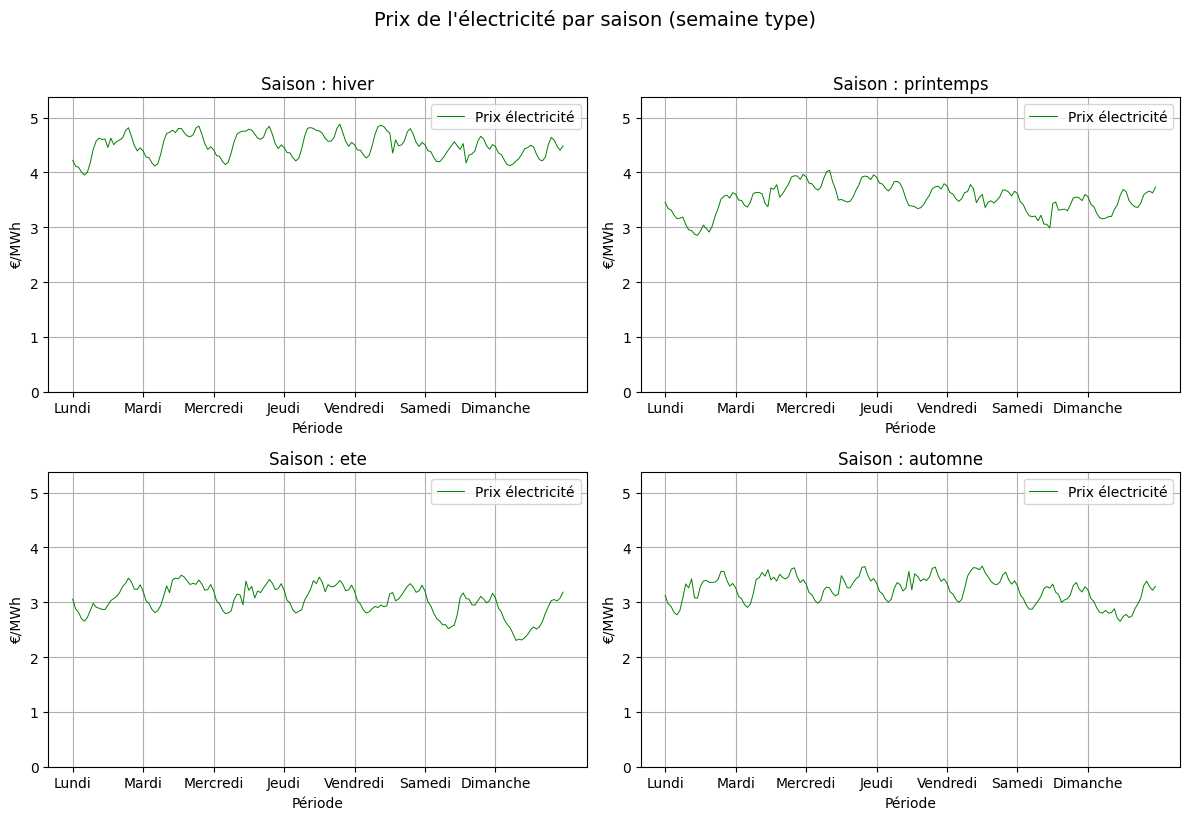

In [ ]:
def price_elec(saison) : 
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df[(df["Saison"] == saison)].copy()

    # Créer le graphique
    plt.figure(figsize=(8, 4))

    plt.plot(filtered_df.index, filtered_df["Prix elec"], label="Prix de l'électricité", color="green", linewidth=0.7)

    # Ajouter labels, titre, légende, grille
    plt.xlabel("Période")
    plt.ylabel("Prix de l'électricité €/MWh")
    plt.title(f"Prix de l'électricité d'une semaine type pour la saison : {saison}")
    plt.ylim(0, filtered_df["Prix elec"].max()*1.1)
    plt.legend()
    plt.grid(True)

    plt.show()

def plot_prices_on_single_figure(df, saisons_list):
    # Créer une figure avec 4 subplots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Prix de l'électricité par saison (semaine type)", y=1.02, fontsize=14)
    
    # Déterminer les limites communes des axes Y
    y_max = df["Prix elec"].max() * 1.1
    
    for i, saison in enumerate(saisons_list):
        filtered_df = df[df["Saison"] == saison].copy()
        ax = axes[i//2, i%2]  # Positionnement dans la grille 2x2
        
        # Tracer le prix
        ax.plot(filtered_df.index, filtered_df["Prix elec"], 
                label="Prix électricité", color="green", linewidth=0.7)
        
        jour_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
        ax.set_xticks(filtered_df.index[::24])
        ax.set_xticklabels(jour_semaine)

        # Paramètres du subplot
        ax.set_title(f"Saison : {saison}")
        ax.set_xlabel("Période")
        ax.set_ylabel("€/MWh")
        ax.set_ylim(0, y_max)  # Même échelle Y pour tous
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()  # Ajuster l'espacement
    plt.show()

plot_prices_on_single_figure(df, SEMAINES.keys())


In [ ]:
print("Nombre d'utilisation de la batterie dans la semaine :", (df['SOC_decharge'] != 0).sum())

Nombre d'utilisation de la batterie dans la semaine : 397


##### Comportement **hebdomadaire** de la batterie (décomposition de l'équilibre offre-demande)

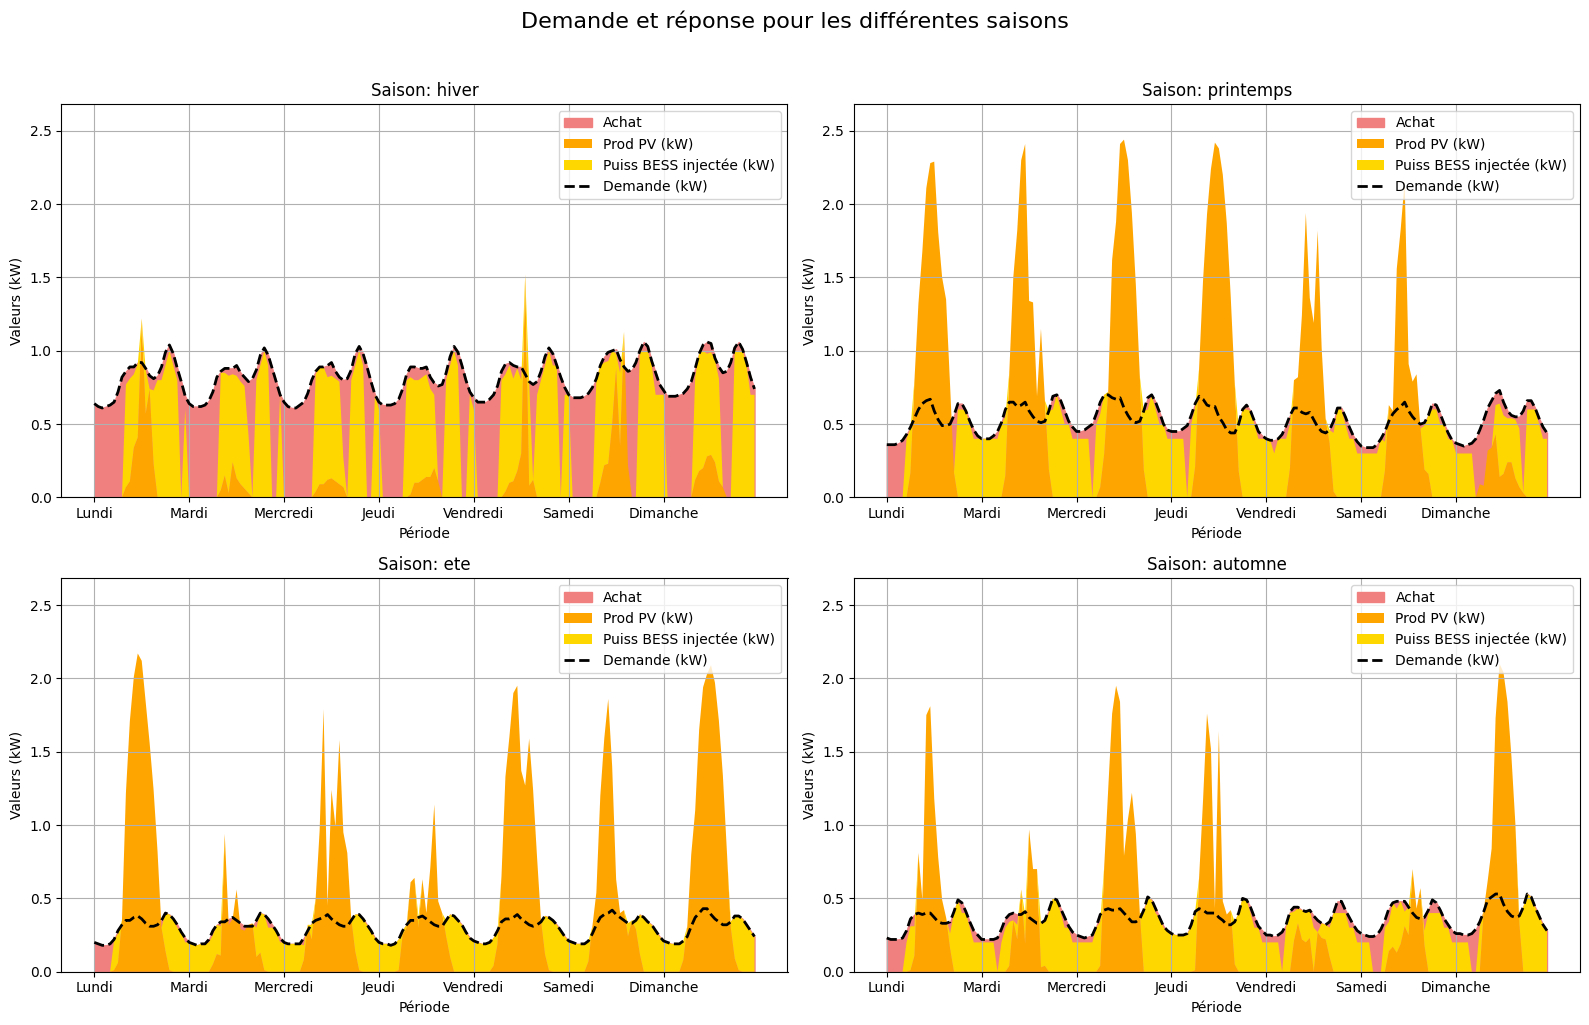

In [ ]:
def bess_injected(saison):    
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df[(df["Saison"] == saison)].copy()

    # Nettoyage des données
    filtered_df["Prod PV"] = filtered_df["Prod PV"].fillna(0).astype(float)
    filtered_df["SOC_decharge"] = filtered_df["SOC_decharge"].fillna(0).astype(float)
    

    # Créer le graphique
    plt.figure(figsize=(8, 4))

    # Utiliser la coubre "Demande" pour afficher l'électricité qu'il reste à acheter (car la colonne "Achat_t" ne fonctionn pas)
    plt.fill_between(filtered_df.index, filtered_df["Demande"], label="Achat", color="pink", alpha=1)  # Remplissage

    # Tracer les zones empilées pour "Prod PV" et "SOC_t"
    plt.stackplot(
        filtered_df.index,  # Axe X (périodes)
        filtered_df["Prod PV"],  # Première zone (Prod PV)
        filtered_df["SOC_decharge"],    # Deuxième zone (SOC_t)
        labels=["Prod PV (kW)", "Puiss BESS injectée (kW)"],  # Labels pour la légende
        colors=["orange", "gold"],     # Couleurs des zones
        alpha=1                               # Transparence
    )
    
    # Tracer la Demande comme une courbe normale
    plt.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", color="black", linestyle = '--' , linewidth=2)

    # Ajouter labels, titre, légende, grille
    plt.xlabel("Période")
    plt.ylabel("Valeurs (kW)")
    plt.title(f"Demande et réponse d'une semaine type (Saison : {saison})")
    # plt.xticks(range(start_period, end_period + 1, 3))  # Tics toutes les 3 périodes
    plt.ylim(0, max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max())*1.1)
    plt.legend(loc="upper right")  # Position de la légende en haut à droite
    
    plt.grid(True)

    # Afficher le graphique
    plt.show()

# for semaine in SEMAINES_LIST : 
#     bess_injected(semaine)

def plot_all_seasons(df, saisons_list):
    # Créer une figure avec 4 sous-graphiques (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle("Demande et réponse pour les différentes saisons", y=1.02, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    y_max = max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        ax = axes[i//2, i%2]  # Positionnement dans la grille
        filtered_df = df[df["Saison"] == saison].copy()
        
        # Nettoyage des données
        filtered_df["Prod PV"] = filtered_df["Prod PV"].fillna(0).astype(float)
        filtered_df["SOC_decharge"] = filtered_df["SOC_decharge"].fillna(0).astype(float)
        
        # Remplissage pour "Achat"
        ax.fill_between(filtered_df.index, filtered_df["Demande"], label="Achat", color="lightcoral", alpha=1)
        
        # Stackplot
        ax.stackplot(filtered_df.index,
                    filtered_df["Prod PV"],
                    filtered_df["SOC_decharge"],
                    labels=["Prod PV (kW)", "Puiss BESS injectée (kW)"],
                    colors=["orange", "gold"],
                    alpha=1)
        
        # Courbe de demande
        ax.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", color="black", linestyle='--', linewidth=2)
        
        jour_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
        ax.set_xticks(filtered_df.index[::24])
        ax.set_xticklabels(jour_semaine)
        
        # Paramètres du sous-graphique
        ax.set_title(f"Saison: {saison}")
        ax.set_xlabel("Période")
        ax.set_ylabel("Valeurs (kW)")
        ax.set_ylim(0, y_max)
        ax.legend(loc="upper right")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Appel de la fonction
plot_all_seasons(df, SEMAINES.keys())

##### Comportement **journalier** de la batterie (décomposition de l'équilibre offre-demande)

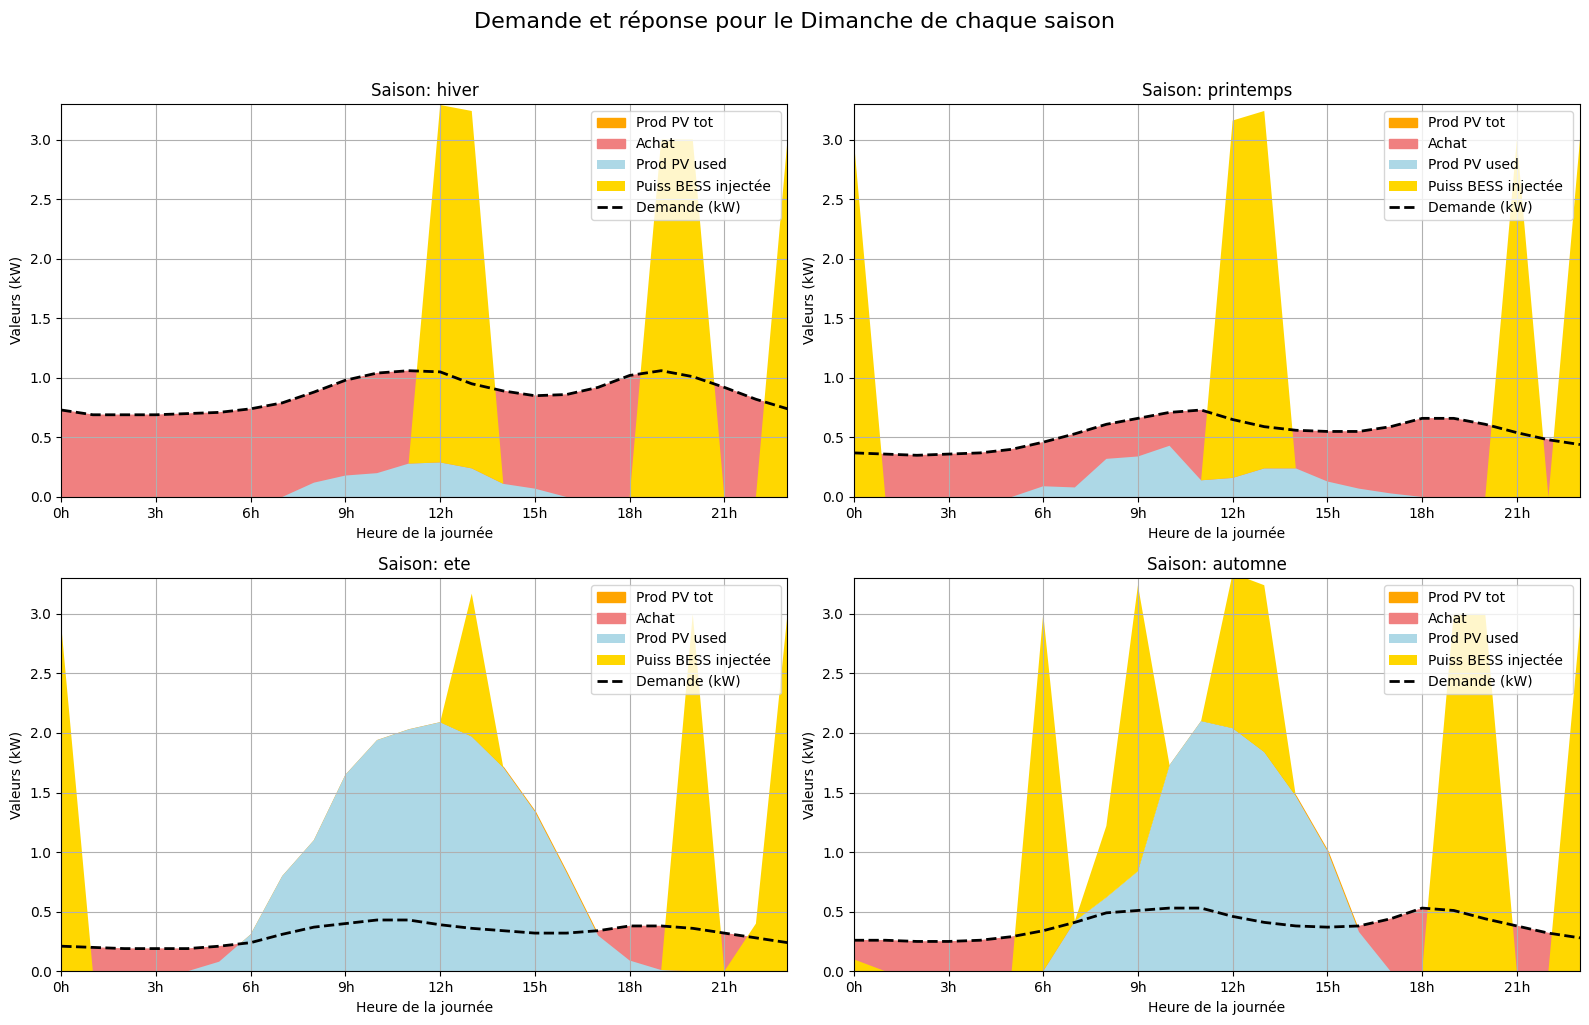

In [ ]:
def plot_all_seasons_day(df, saisons_list, jour_cible):
    # Mapping des jours de la semaine
    jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    
    # Créer une figure avec 4 sous-graphiques (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Demande et réponse pour le {jour_cible} de chaque saison", y=1.02, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    y_max = max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        ax = axes[i//2, i%2]  # Positionnement dans la grille
        
        # Filtrer la saison et extraire le jour cible
        filtered_df = df[df["Saison"] == saison].copy()
        idx_jour = jours_semaine.index(jour_cible)
        daily_data = filtered_df.iloc[idx_jour*24 : (idx_jour+1)*24].copy()  # Extraire 24h pour le jour cible
        
        # Nettoyage des données
        daily_data["Prod PV"] = daily_data["Prod PV"].fillna(0).astype(float)
        daily_data["SOC_decharge"] = daily_data["SOC_decharge"].fillna(0).astype(float)
        
        # Remplissage pour "Achat"
        ax.fill_between(range(24), daily_data["Demande"], label="Achat", color="lightcoral", alpha=1)
        
        # Stackplot
        ax.stackplot(range(24),
                    daily_data["Prod PV"],
                    daily_data["SOC_decharge"],
                    labels=["Prod PV (kW)", "Puiss BESS injectée (kW)"],
                    colors=["orange", "gold"],
                    alpha=1)
        
        # Courbe de demande
        ax.plot(range(24), daily_data["Demande"], label="Demande (kW)", color="black", linestyle='--', linewidth=2)
        
        # Configuration des ticks horaires
        ax.set_xticks(range(0, 24, 3))
        ax.set_xticklabels([f"{h}h" for h in range(0, 24, 3)])
        
        # Paramètres du sous-graphique
        ax.set_title(f"Saison: {saison}")
        ax.set_xlabel("Heure de la journée")
        ax.set_ylabel("Valeurs (kW)")
        ax.set_xlim(0, 23)
        ax.set_ylim(0, y_max)
        ax.legend(loc="upper right")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_all_seasons_day_well(df, saisons_list, jour_cible):
    # Mapping des jours de la semaine
    jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    
    # Créer une figure avec 4 sous-graphiques (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Demande et réponse pour le {jour_cible} de chaque saison", y=1.02, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    y_max = max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        ax = axes[i//2, i%2]  # Positionnement dans la grille
        
        # Filtrer la saison et extraire le jour cible
        filtered_df = df[df["Saison"] == saison].copy()
        idx_jour = jours_semaine.index(jour_cible)
        daily_data = filtered_df.iloc[idx_jour*24 : (idx_jour+1)*24].copy()  # Extraire 24h pour le jour cible
        
        # Nettoyage des données
        daily_data["Prod PV"] = daily_data["Prod PV"].fillna(0).astype(float)
        daily_data["SOC_decharge"] = daily_data["SOC_decharge"].fillna(0).astype(float)
        
        # Remplissage pour "Achat"
        ax.fill_between(range(24), daily_data["Prod PV"], label="Prod PV tot", color="orange", alpha=1)
        ax.fill_between(range(24), daily_data["Demande"], label="Achat", color="lightcoral", alpha=1)
        
        # Stackplot
        ax.stackplot(range(24),
                    daily_data["Prod PV"] - daily_data["Well"].round(3),
                    daily_data["SOC_decharge"],
                    labels=["Prod PV used", "Puiss BESS injectée "],
                    colors=["lightblue", "gold"],
                    alpha=1)
        
        # Courbe de demande
        ax.plot(range(24), daily_data["Demande"], label="Demande (kW)", color="black", linestyle='--', linewidth=2)
        
        # Configuration des ticks horaires
        ax.set_xticks(range(0, 24, 3))
        ax.set_xticklabels([f"{h}h" for h in range(0, 24, 3)])
        
        # Paramètres du sous-graphique
        ax.set_title(f"Saison: {saison}")
        ax.set_xlabel("Heure de la journée")
        ax.set_ylabel("Valeurs (kW)")
        ax.set_xlim(0, 23)
        ax.set_ylim(0, y_max)
        ax.legend(loc="upper right")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# --- Appel des fonctions --- #
# plot_all_seasons_day(df, SEMAINES.keys(), 'Mercredi')
plot_all_seasons_day_well(df, SEMAINES.keys(), 'Dimanche')

##### Évolution du SOC de la batterie

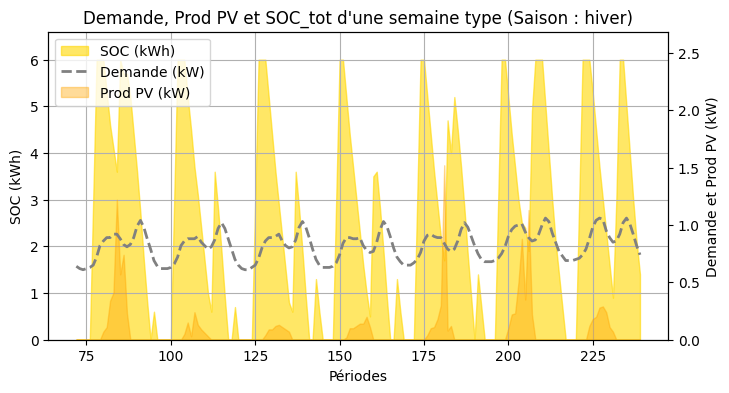

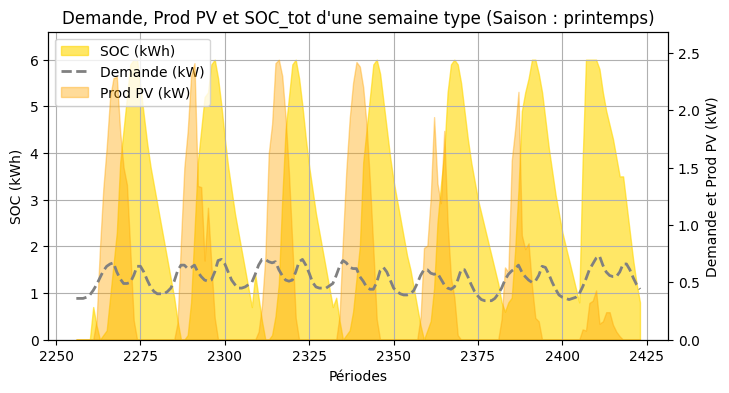

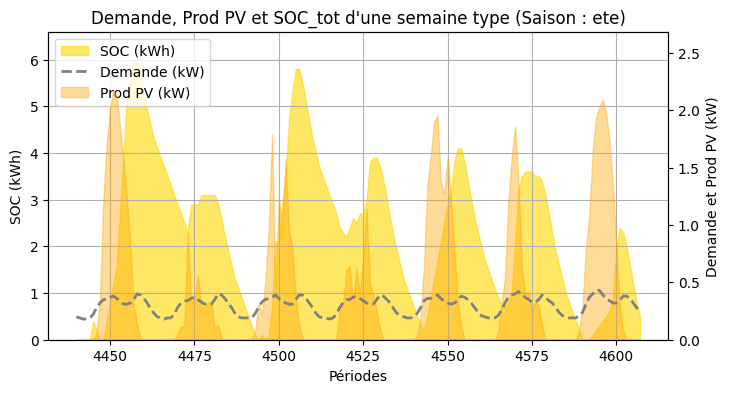

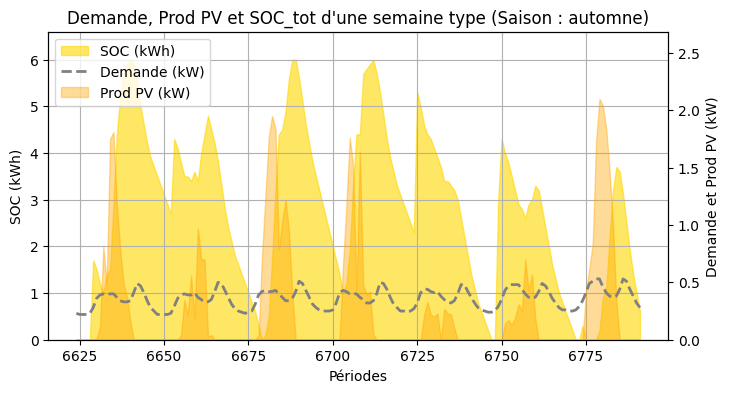

In [ ]:
def soc(saison) :
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df[(df["Saison"] == saison)].copy()
    
    # Créer une figure et un premier axe Y
    fig, ax1 = plt.subplots(figsize=(8, 4))

    ax1.fill_between(filtered_df.index, filtered_df["SOC_t"], label="SOC (kWh)", color="gold", alpha=0.6)

    ax1.set_xlabel("Périodes")
    ax1.set_ylabel("SOC (kWh)")
    ax1.tick_params(axis='y')
    ax1.grid(True)

    # Créer un deuxième axe Y partageant le même axe X
    ax2 = ax1.twinx()

    # Tracer la Demande et la Prod PV sur le premier axe Y (kWh)
    ax2.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", linestyle='--', color="grey", linewidth=2)
    ax2.fill_between(filtered_df.index, filtered_df["Prod PV"], label="Prod PV (kW)", color="orange", alpha=0.4)

    # Configurer le deuxième axe Y
    ax2.set_xlabel("Période")
    ax2.set_ylabel("Demande et Prod PV (kW)")    
    ax2.tick_params(axis='y')

    # ax1.set_xticks(range(start_period, end_period + 1, 3))  # Tics toutes les 3 périodes

    # Ajouter un titre
    plt.title(f"Demande, Prod PV et SOC_tot d'une semaine type (Saison : {saison})")
    ax1.set_ylim(0, df["SOC_t"].max()*1.1)
    ax2.set_ylim(0, max(df["Demande"].max(), df["Prod PV"].max())*1.1)

    # Combiner les légendes des deux axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.show()

for semaine in SEMAINES.keys() : 
    soc(semaine)

# National

In [ ]:
RESULTS_DIR = '/Users/vincentboltz/Documents/DOC_ENPC/Projet_IFPEN/Dossier_Modele_Complet/Modele_chronologique/results.csv'

df_nat = pd.read_csv(RESULTS_DIR, delimiter=',') 
display(df.iloc[473:493])

,Saison,Date,Heure,Demande,Prod PV,SOC_t,Vente,Achat,Well,Prix elec,SOC_charge,SOC_decharge,Achat_t
4577,ete,7/10/2021,17,0.35,0.29,3.5,0.0,0.0,0.04,2.948,0.0,0.06,0.0
4578,ete,7/10/2021,18,0.39,0.12,3.4,0.0,0.0,0.03,3.029,0.0,0.27,0.0
4579,ete,7/10/2021,19,0.37,0.00,3.1,0.0,0.0,0.03,3.108,0.0,0.37,0.0
4580,ete,7/10/2021,20,0.34,0.00,2.7,0.0,0.0,0.06,3.058,0.0,0.34,0.0
4581,ete,7/10/2021,21,0.32,0.00,2.3,0.0,0.0,0.08,2.989,0.0,0.32,0.0
4582,ete,7/10/2021,22,0.28,0.00,1.9,0.0,0.0,0.02,3.033,0.0,0.28,0.0
4583,ete,7/10/2021,23,0.24,0.00,1.6,0.0,0.0,0.06,3.166,0.0,0.24,0.0
4584,ete,7/11/2021,0,0.21,0.00,1.3,0.0,0.0,0.09,3.079,0.0,0.21,0.0
4585,ete,7/11/2021,1,0.20,0.00,1.0,0.0,0.0,0.00,2.896,0.0,0.20,0.0
4586,ete,7/11/2021,2,0.19,0.00,0.8,0.0,0.0,0.01,2.820,0.0,0.19,0.0


##### Demande annuelle MW

In [ ]:
def graph(period) : 
    start_period, end_period = period
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df_nat[(df_nat["periode"] >= start_period) & (df["periode"] <= end_period)].copy()

    # Créer le graphique
    plt.figure(figsize=(10, 4))
    
    plt.plot(filtered_df["periode"], filtered_df["demande brute"], label="Consommation d'électricité brute (MW)", color="red", linewidth=0.6)
    plt.plot(filtered_df["periode"], filtered_df["demande brute"], label="Consommation d'électricité nette (MW)", color="blue", linewidth=0.5)

    # Ajouter labels, titre, légende, grille
    plt.xlabel("Période")
    plt.ylabel("Consommation d'électricité (MW)")
    plt.title(f"Consommation nationale d'électricité (Périodes {start_period} à {end_period})")
    plt.xticks(range(start_period, end_period + 1, 91))  # Tics toutes les 3 périodes
    plt.ylim(0, filtered_df["demande brute"].max()*1.1)
    plt.legend()
    plt.grid(True)

    plt.show()

graph((0, 1095))

KeyError: 'periode'